#### Este notebook muestra el proceso de entrenamiento del modelo 4K

In [1]:
#IMPORTAMOS LIBRERIAS
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
warnings.filterwarnings('ignore')

In [2]:
#VERIFICAMOS SI TENEMOS NUESTRA GPU DISPONIBLE Y LAS VERSIONES DE PYTORCH Y CUDA
import torch
import torchvision

print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 
print("Version Pytorch:", torch.__version__)
print("Version Torchvision:", torchvision.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

True
NVIDIA GeForce RTX 4050 Laptop GPU
Version Pytorch: 2.5.1+cu118
Version Torchvision: 0.20.1+cu118
CUDA disponible: True
CUDA version: 11.8


In [5]:
#Importamos los datos necesarios para el entrenamiento
train_images = 'Dataset 4K/train4k/images'
train_labels = 'Dataset 4K/train4k/labels'

test_images = 'Dataset 4K/test4k/images'
test_labels = 'Dataset 4K/test4k/labels'

val_images = 'Dataset 4K/valid4k/images'
val_labels = 'Dataset 4K/valid4k/labels'

In [6]:
print('Numero de imagenes de entrenamiento: ' + str(len(os.listdir(train_images))))
print('Numero de etiquetas de entrenamiento: ' + str(len(os.listdir(train_labels))))
print('Numero de imagenes de validacion: ' + str(len(os.listdir(val_images))))
print('Numero de etiquetas de validacion ' + str(len(os.listdir(val_labels))))
print('Numero de imagenes de testeo: ' + str(len(os.listdir(test_images))))
print('Numero de etiquetas de testeo ' + str(len(os.listdir(test_labels))))
print('Total imagenes: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Numero de imagenes de entrenamiento: 3698
Numero de etiquetas de entrenamiento: 3698
Numero de imagenes de validacion: 412
Numero de etiquetas de validacion 412
Numero de imagenes de testeo: 118
Numero de etiquetas de testeo 118
Total imagenes: 4228


In [7]:
#ANALISIS DE FORMATO CORRECTO DE ETIQUETAS YOLO
def verify_yolo_labels(labels_dir):
    errors = []
    required_columns = 5
    class_id = 0  
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue            
        file_path = os.path.join(labels_dir, label_file)     
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()                
                for line_num, line in enumerate(lines, 1):
                    line = line.strip()                    
                    if not line:
                        continue                         
                    parts = line.split()
                    
                    if len(parts) != required_columns:
                        errors.append(f"{label_file} línea {line_num}: Número incorrecto de valores ({len(parts)} en lugar de 5)")
                        continue
                    try:
                        cls = int(parts[0])
                        if cls != class_id:
                            errors.append(f"{label_file} línea {line_num}: Clase incorrecta ({cls} en lugar de 0)")
                    except ValueError:
                        errors.append(f"{label_file} línea {line_num}: Formato de clase inválido ('{parts[0]}')")
                    
                    for i, coord in enumerate(parts[1:], start=1):
                        try:
                            num = float(coord)
                            if not (0.0 <= num <= 1.0):
                                errors.append(f"{label_file} línea {line_num}: Valor {['x_center', 'y_center', 'width', 'height'][i-1]} ({num}) fuera de rango [0, 1]")
                        except ValueError:
                            errors.append(f"{label_file} línea {line_num}: Formato numérico inválido en posición {i} ('{coord}')")                    
                    try:
                        width = float(parts[3])
                        height = float(parts[4])
                        if width <= 0 or height <= 0:
                            errors.append(f"{label_file} línea {line_num}: Bounding box con tamaño inválido (ancho: {width}, alto: {height})")
                    except:
                        pass                         
        except Exception as e:
            errors.append(f"{label_file}: Error al leer archivo - {str(e)}")
            
    return errors

In [8]:
def verification_labels(directory, name):
    labels_directory = directory
    errors = verify_yolo_labels(labels_directory)
    if errors:
        print(f"Se encontraron {len(errors)} errores:")
        for error in errors:
            print(f"• {error}")
    else:
        print(f"Todos los archivos de etiquetas del conjunto {name} están correctos")


In [9]:
verification_labels("Dataset 4K/train4k/labels", "Train")
verification_labels("Dataset 4K/valid4k/labels", "Test")
verification_labels("Dataset 4K/test4k/labels", "Validation")

Todos los archivos de etiquetas del conjunto Train están correctos
Todos los archivos de etiquetas del conjunto Test están correctos
Todos los archivos de etiquetas del conjunto Validation están correctos


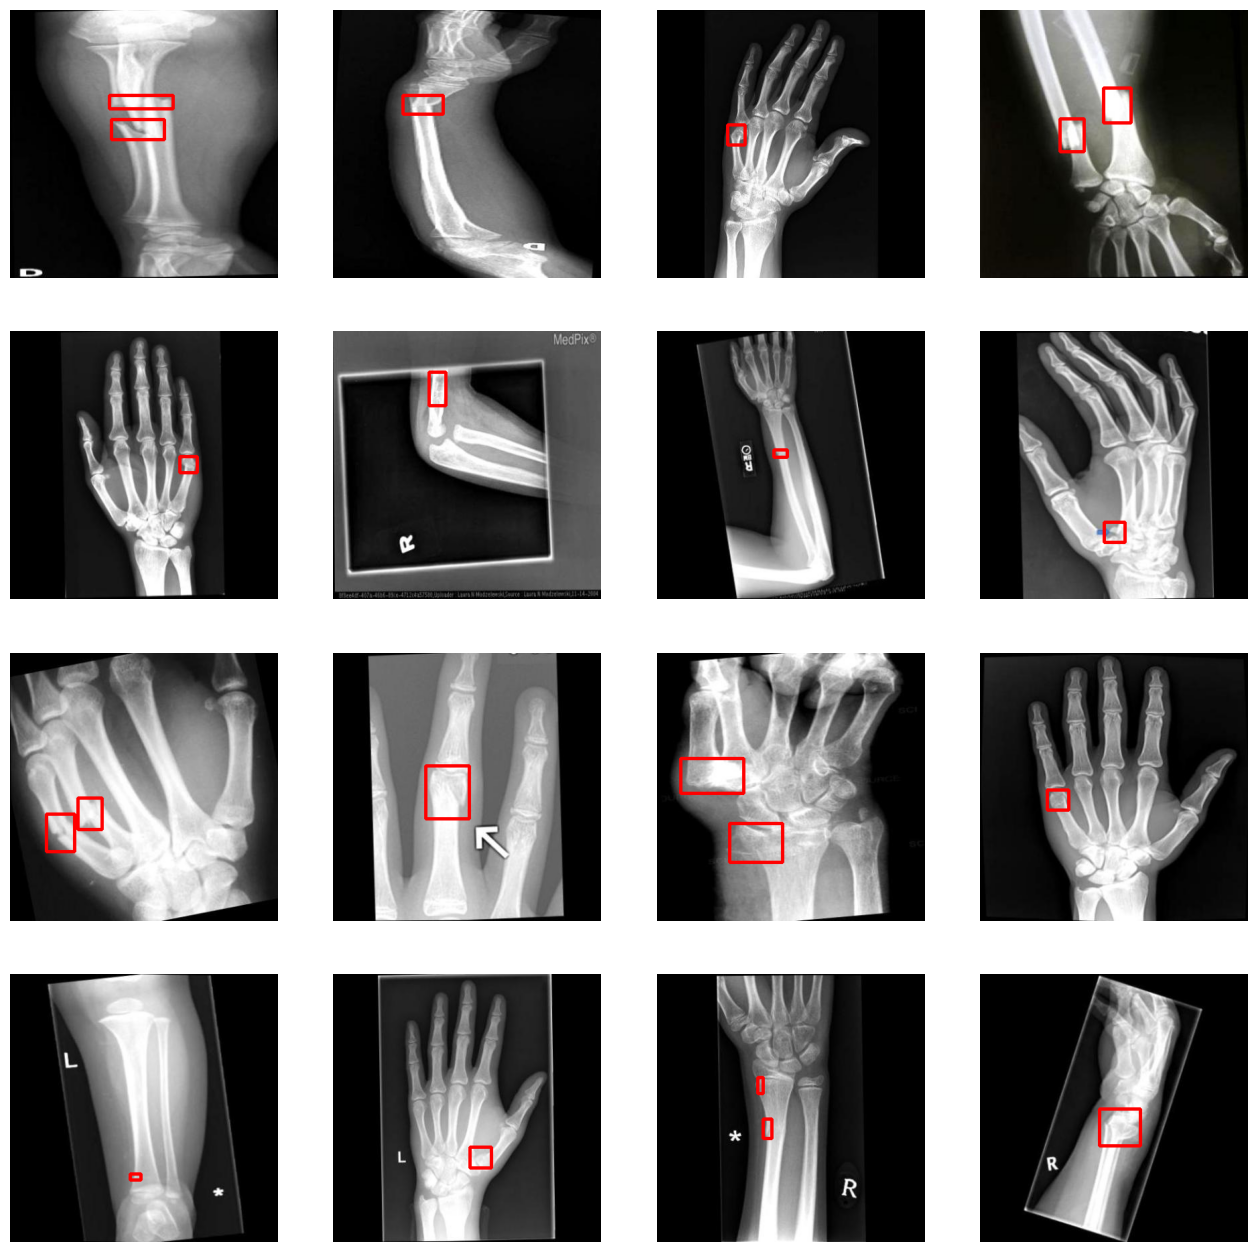

In [10]:
#VISUALZACION DE IMAGENES DEL CONJUNTO DE ENTRENAMIENTO
image_files = os.listdir(train_images)
random_images = random.sample(image_files, 16)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))


for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0,0, 255), 3)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [11]:
#CARGA MODELO
model = YOLO("yolov8m.pt")

### Entrenamiento modelo (descomentar para entrenar)

In [12]:
#ENTRENAMIENTO MODELO
#model.train(data = 'data4k.yaml', epochs = 40, imgsz = 512,cbatch=16)

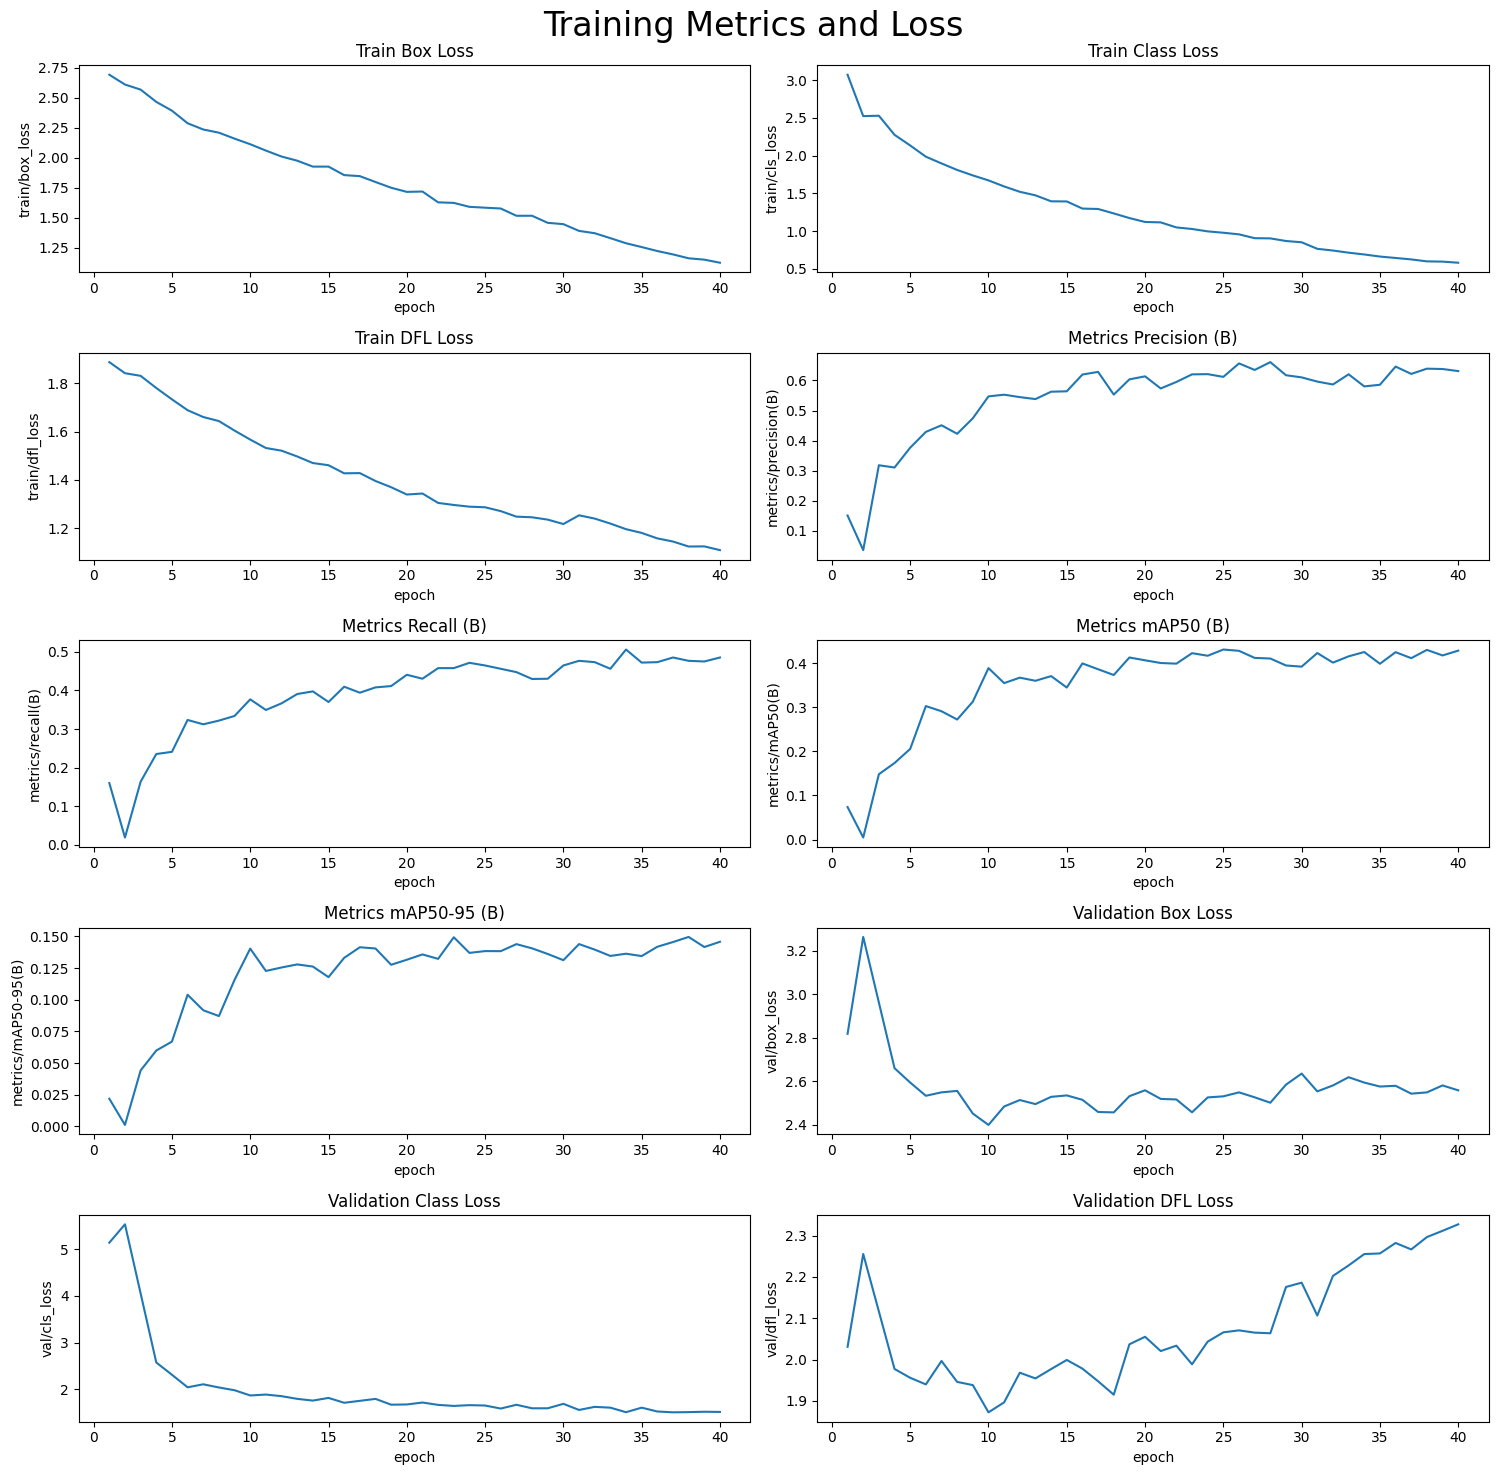

In [13]:
#VISUALIZACION DE LOS RESULTADOS DEL ENTRENAMIENTO
df = pd.read_csv('runs/detect/train9/results.csv')
df.columns = df.columns.str.strip()
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))


sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

### Evaluacion Modelo con Datos de Prueba

In [15]:
#CARGAR EL MODELO ENTRENANDO 4K
model = YOLO('runs/detect/train9/weights/best.pt') 

In [8]:
metrics_4k = model.val(data='data4k.yaml', split="test", imgsz=512)

Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)


val: Scanning C:\Users\zekro\Desktop\Ivan\PostGradoUMSS\Estadistica\Final Project\YOLO-ROBOFLOW\Fracture_Detection_yolo
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<0


                   all        118        155      0.782        0.6      0.618      0.259
Speed: 1.4ms preprocess, 13.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\detect\val15


In [20]:
#Resultados evaluacion datos de prueba
precision = metrics_4k.box.p
recall = metrics_4k.box.r
mAP50 = metrics_4k.box.map50
mAP50_95 = metrics_4k.box.map
fitness = metrics_4k.box.fitness

print(precision)
print(recall)
print(mAP50)
print(mAP50_95)

[    0.78202]
[        0.6]
0.6184853602032978
0.258529130779216



0: 320x512 1 fracture detected, 195.4ms
Speed: 16.0ms preprocess, 195.4ms inference, 488.2ms postprocess per image at shape (1, 3, 320, 512)


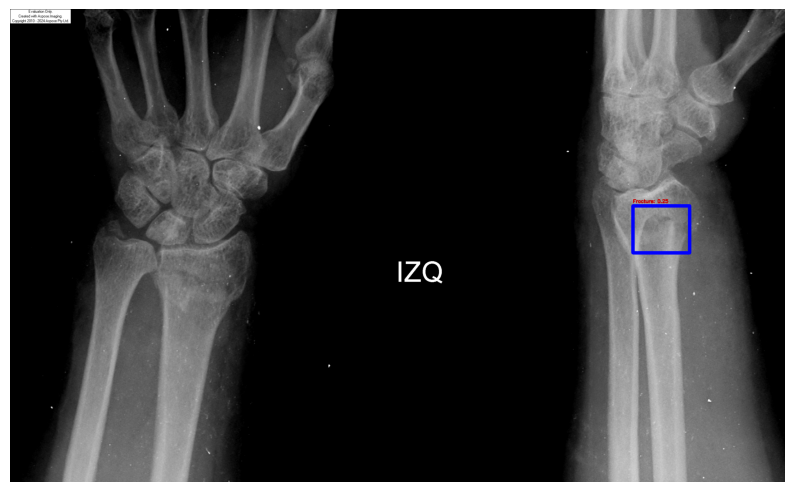

In [17]:
#TEST DE IMAGENS CNS
image_path = "Datos usados para evaluar CNS/364.dcm.png"
image = cv2.imread(image_path)


results = model.predict(source=image, save=False, imgsz=512) 


for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        label = int(box.cls)  
        score = box.conf 

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 10)  
        cv2.putText(image, f'Fracture: {float(score):.2f}', (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2) 


# Convertir la imagen de BGR a RGB para mostrar con Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()